<a href="https://colab.research.google.com/github/nacho-gonz/MdD-TUIA-2024/blob/master/TP2/TP_Mineria_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Información.

Integrantes: Noir Nicolás, González Ignacio

Materia: Minería de datos

Año: 2024



# Librerías

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.exceptions import DataConversionWarning
from sklearn.exceptions import ConvergenceWarning
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore")

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from graphviz import Source
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

### 1 Descargar el conjunto de datos, 1000_Companies. para realizar el trabajo práctico. Analizar los atributos del conjunto de datos (distribuciones, valores, outliers, tipos de datos, etc.) y elegir un método de estandarización.

In [168]:
df_comp = pd.read_csv('https://raw.githubusercontent.com/Nicolas-Noir/Archivos-TUIA-2024-2do-cuatrimestre/main/1000_Companies.csv')
df_pokemon = pd.read_csv('https://raw.github.com/Nicolas-Noir/Archivos-TUIA-2024-2do-cuatrimestre/main/PokemonDBCart.csv')

In [169]:
x_train, x_test, y_train, y_test = train_test_split(df_comp.drop('Profit', axis=1), df_comp['Profit'], test_size=0.2, random_state=7655377)
x_train2, x_test2, y_train2, y_test2 = train_test_split(df_comp.drop('Profit', axis=1), df_comp['Profit'], test_size=0.3, random_state=7655377)
x_train.shape, x_test.shape, y_train.shape, y_test.shape,x_train2.shape, x_test2.shape,y_train2.shape, y_test2.shape

((800, 4), (200, 4), (800,), (200,), (700, 4), (300, 4), (700,), (300,))

In [170]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 837 to 114
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       800 non-null    float64
 1   Administration  800 non-null    float64
 2   MarketingSpend  800 non-null    float64
 3   State           800 non-null    object 
dtypes: float64(3), object(1)
memory usage: 31.2+ KB


El dataset no presenta valores faltantes, entonces no es necesario el proceso de imputación de valores faltantes.

In [171]:
x_train.describe()

,RyD_Spend,Administration,MarketingSpend
count,800.0,800.0,800.0
mean,81074.8,122822.2,224450.5
std,46523.1,12768.0,91564.0
min,0.0,51283.1,0.0
25%,41966.5,116525.7,148905.5
50%,79401.0,122292.5,223015.8
75%,123376.7,129014.1,306052.9
max,162597.7,321652.1,443898.5


El dataset presenta variables con escalas diferentes, esto nos lleva a tener que escalar las variables para no tener posibles problemas en la creación del arbol de decisiones.

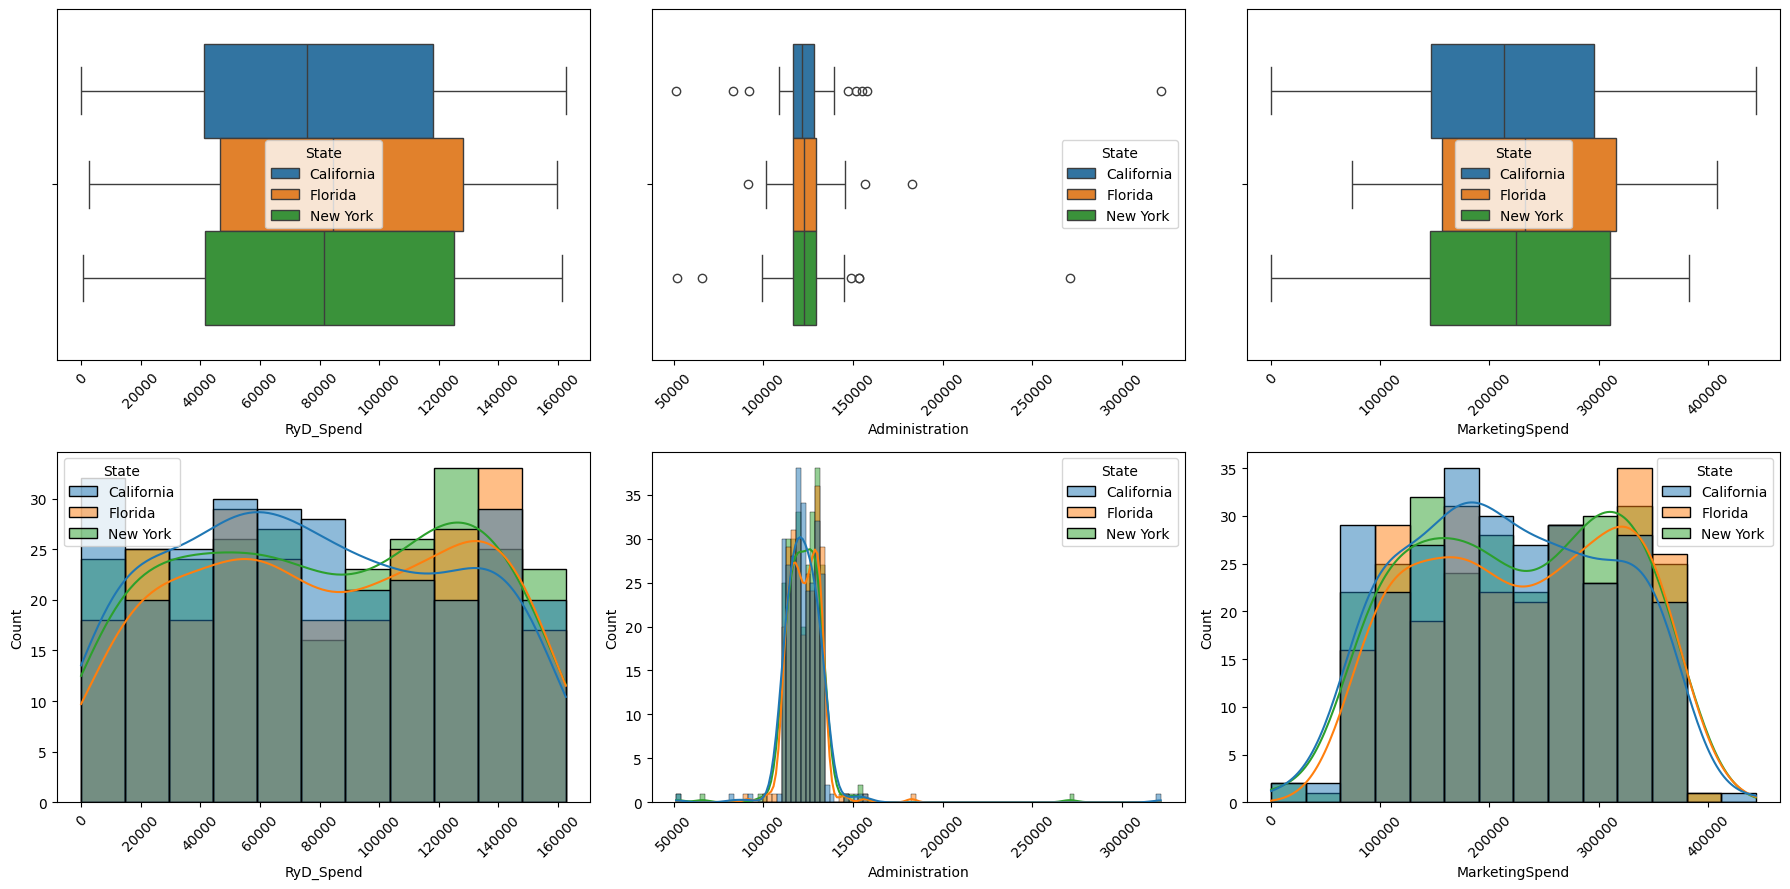

In [172]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))

for i, name in enumerate(x_train[['RyD_Spend','Administration','MarketingSpend']]):

    sns.boxplot(x=name, data=x_train, orient='h', ax=axes[0, i], hue='State')
    axes[0, i].tick_params(axis='x', rotation=45)

    sns.histplot(x=name, data=x_train, ax=axes[1, i], kde=True, hue='State')
    axes[1, i].tick_params(axis='x', rotation=45)


fig.tight_layout()
plt.show()

RyD_Spend presenta una distribución uniforme, Administration presenta una distribución normál con algunos outliers y MarketingSpend presenta una distribución bimodal. Viendo que una de las variables presenta outliers decidimos que escalaremos los datos con RobustScaler.

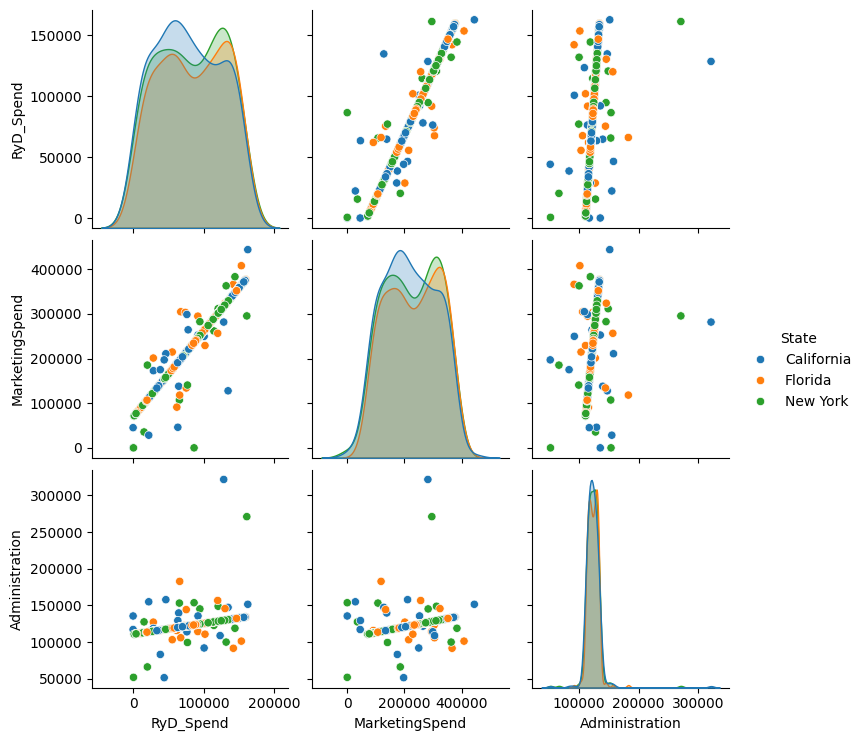

In [173]:
sns.pairplot(x_train, hue='State',x_vars=['RyD_Spend','MarketingSpend','Administration'],y_vars=['RyD_Spend','MarketingSpend','Administration'])
plt.show()

Todas las relaciones entre las variables parecen ser de tipo lineal, aún teniendo un pequeño ruido que baja esta correlación.

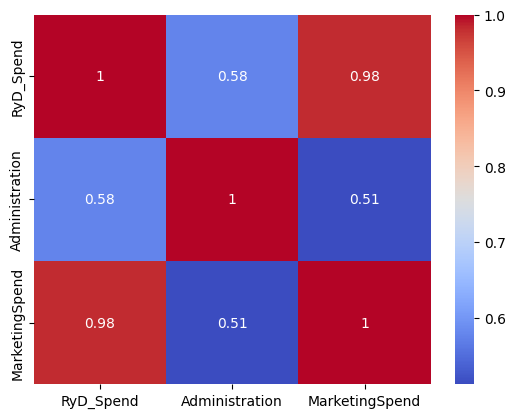

In [174]:
matriz = x_train[['RyD_Spend','Administration','MarketingSpend']].corr()
sns.heatmap(matriz, annot=True, cmap='coolwarm')
plt.show()

Aquí vemos con más detalle los valores del coeficiente de correlación de pearson, viendo que RyD_Spend con MarketingSpend tiene una correlación lineal muy fuerte de 0.98, Administración y RyD_Spend tienen una correlación lineal media de 0.58 y MarketingSpend y Administración tienen una correlación lineal media de 0.52.

In [175]:
label_enc = LabelEncoder()
x_train['State_codif'] = label_enc.fit_transform(x_train['State'])
x_test['State_codif'] = label_enc.transform(x_test['State'])
x_train2['State_codif'] = label_enc.transform(x_train2['State'])
x_test2['State_codif'] = label_enc.transform(x_test2['State'])

In [176]:
x_train.drop('State',axis=1,inplace=True)
x_test.drop('State',axis=1,inplace=True)
x_train2.drop('State',axis=1,inplace=True)
x_test2.drop('State',axis=1,inplace=True)

In [177]:
state_train = x_train['State_codif']
state_test = x_test['State_codif']
state_train2 = x_train2['State_codif']
state_test2 = x_test2['State_codif']

In [178]:
x_train.drop('State_codif',axis=1,inplace=True)
x_test.drop('State_codif',axis=1,inplace=True)
x_train2.drop('State_codif',axis=1,inplace=True)
x_test2.drop('State_codif',axis=1,inplace=True)

In [179]:
robust_scaler = RobustScaler(with_centering=False).set_output(transform='pandas')
x_train_esc = robust_scaler.fit_transform(x_train)
x_test_esc = robust_scaler.transform(x_test)
x_train_esc2 = robust_scaler.transform(x_train2)
x_test_esc2 = robust_scaler.transform(x_test2)

In [180]:
x_train_esc.describe()

,RyD_Spend,Administration,MarketingSpend
count,800.0,800.0,800.0
mean,1.0,9.8,1.4
std,0.6,1.0,0.6
min,0.0,4.1,0.0
25%,0.5,9.3,0.9
50%,1.0,9.8,1.4
75%,1.5,10.3,1.9
max,2.0,25.8,2.8


In [181]:
x_train_esc['State_codif'] = state_train
x_test_esc['State_codif'] = state_test
x_train_esc2['State_codif'] = state_train2
x_test_esc2['State_codif'] = state_test2

Podemos observar que según la documentación de sklearn de RobustScaler cuando la distribución de la variable es normal al escalar el dataset esta va a presentar una desviación estandar de 1 y en caso de tener valores diferentes de uno, esto nos dice que su distribución no es normal, como observamos anteriormente en los histogramas.

## 2 Realizar la estimación del atributo Profit utilizando árboles de decisión (Regresión)

In [182]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

decision_tree_profit_reg = DecisionTreeRegressor(random_state=5232)

param_grid = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'min_samples_leaf': [1,2,3,4],
    'min_samples_split': [2,3,4,5,6,7],  # min_samples_split debe ser >= 2 para evitar errores
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    'criterion': ['squared_error', 'absolute_error']  # Para regresión
}

grid_search = GridSearchCV(estimator=decision_tree_profit_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)

grid_search.fit(x_train_esc, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

Mejores hiperparámetros encontrados:
{'criterion': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0}


In [183]:
decision_tree_regresion = tree.DecisionTreeRegressor(max_depth=7, min_samples_leaf=1, min_samples_split=6, min_weight_fraction_leaf =0.0, criterion='squared_error', random_state=629426)

decision_tree_regresion.fit(x_train_esc, y_train)

DecisionTreeRegressor(max_depth=7, min_samples_split=6, random_state=629426)

In [184]:
decision_tree_regresion2 = tree.DecisionTreeRegressor(max_depth=7, min_samples_leaf=1, min_samples_split=6, min_weight_fraction_leaf =0.0, criterion='squared_error', random_state=629426)

decision_tree_regresion2.fit(x_train_esc2, y_train2)

DecisionTreeRegressor(max_depth=7, min_samples_split=6, random_state=629426)

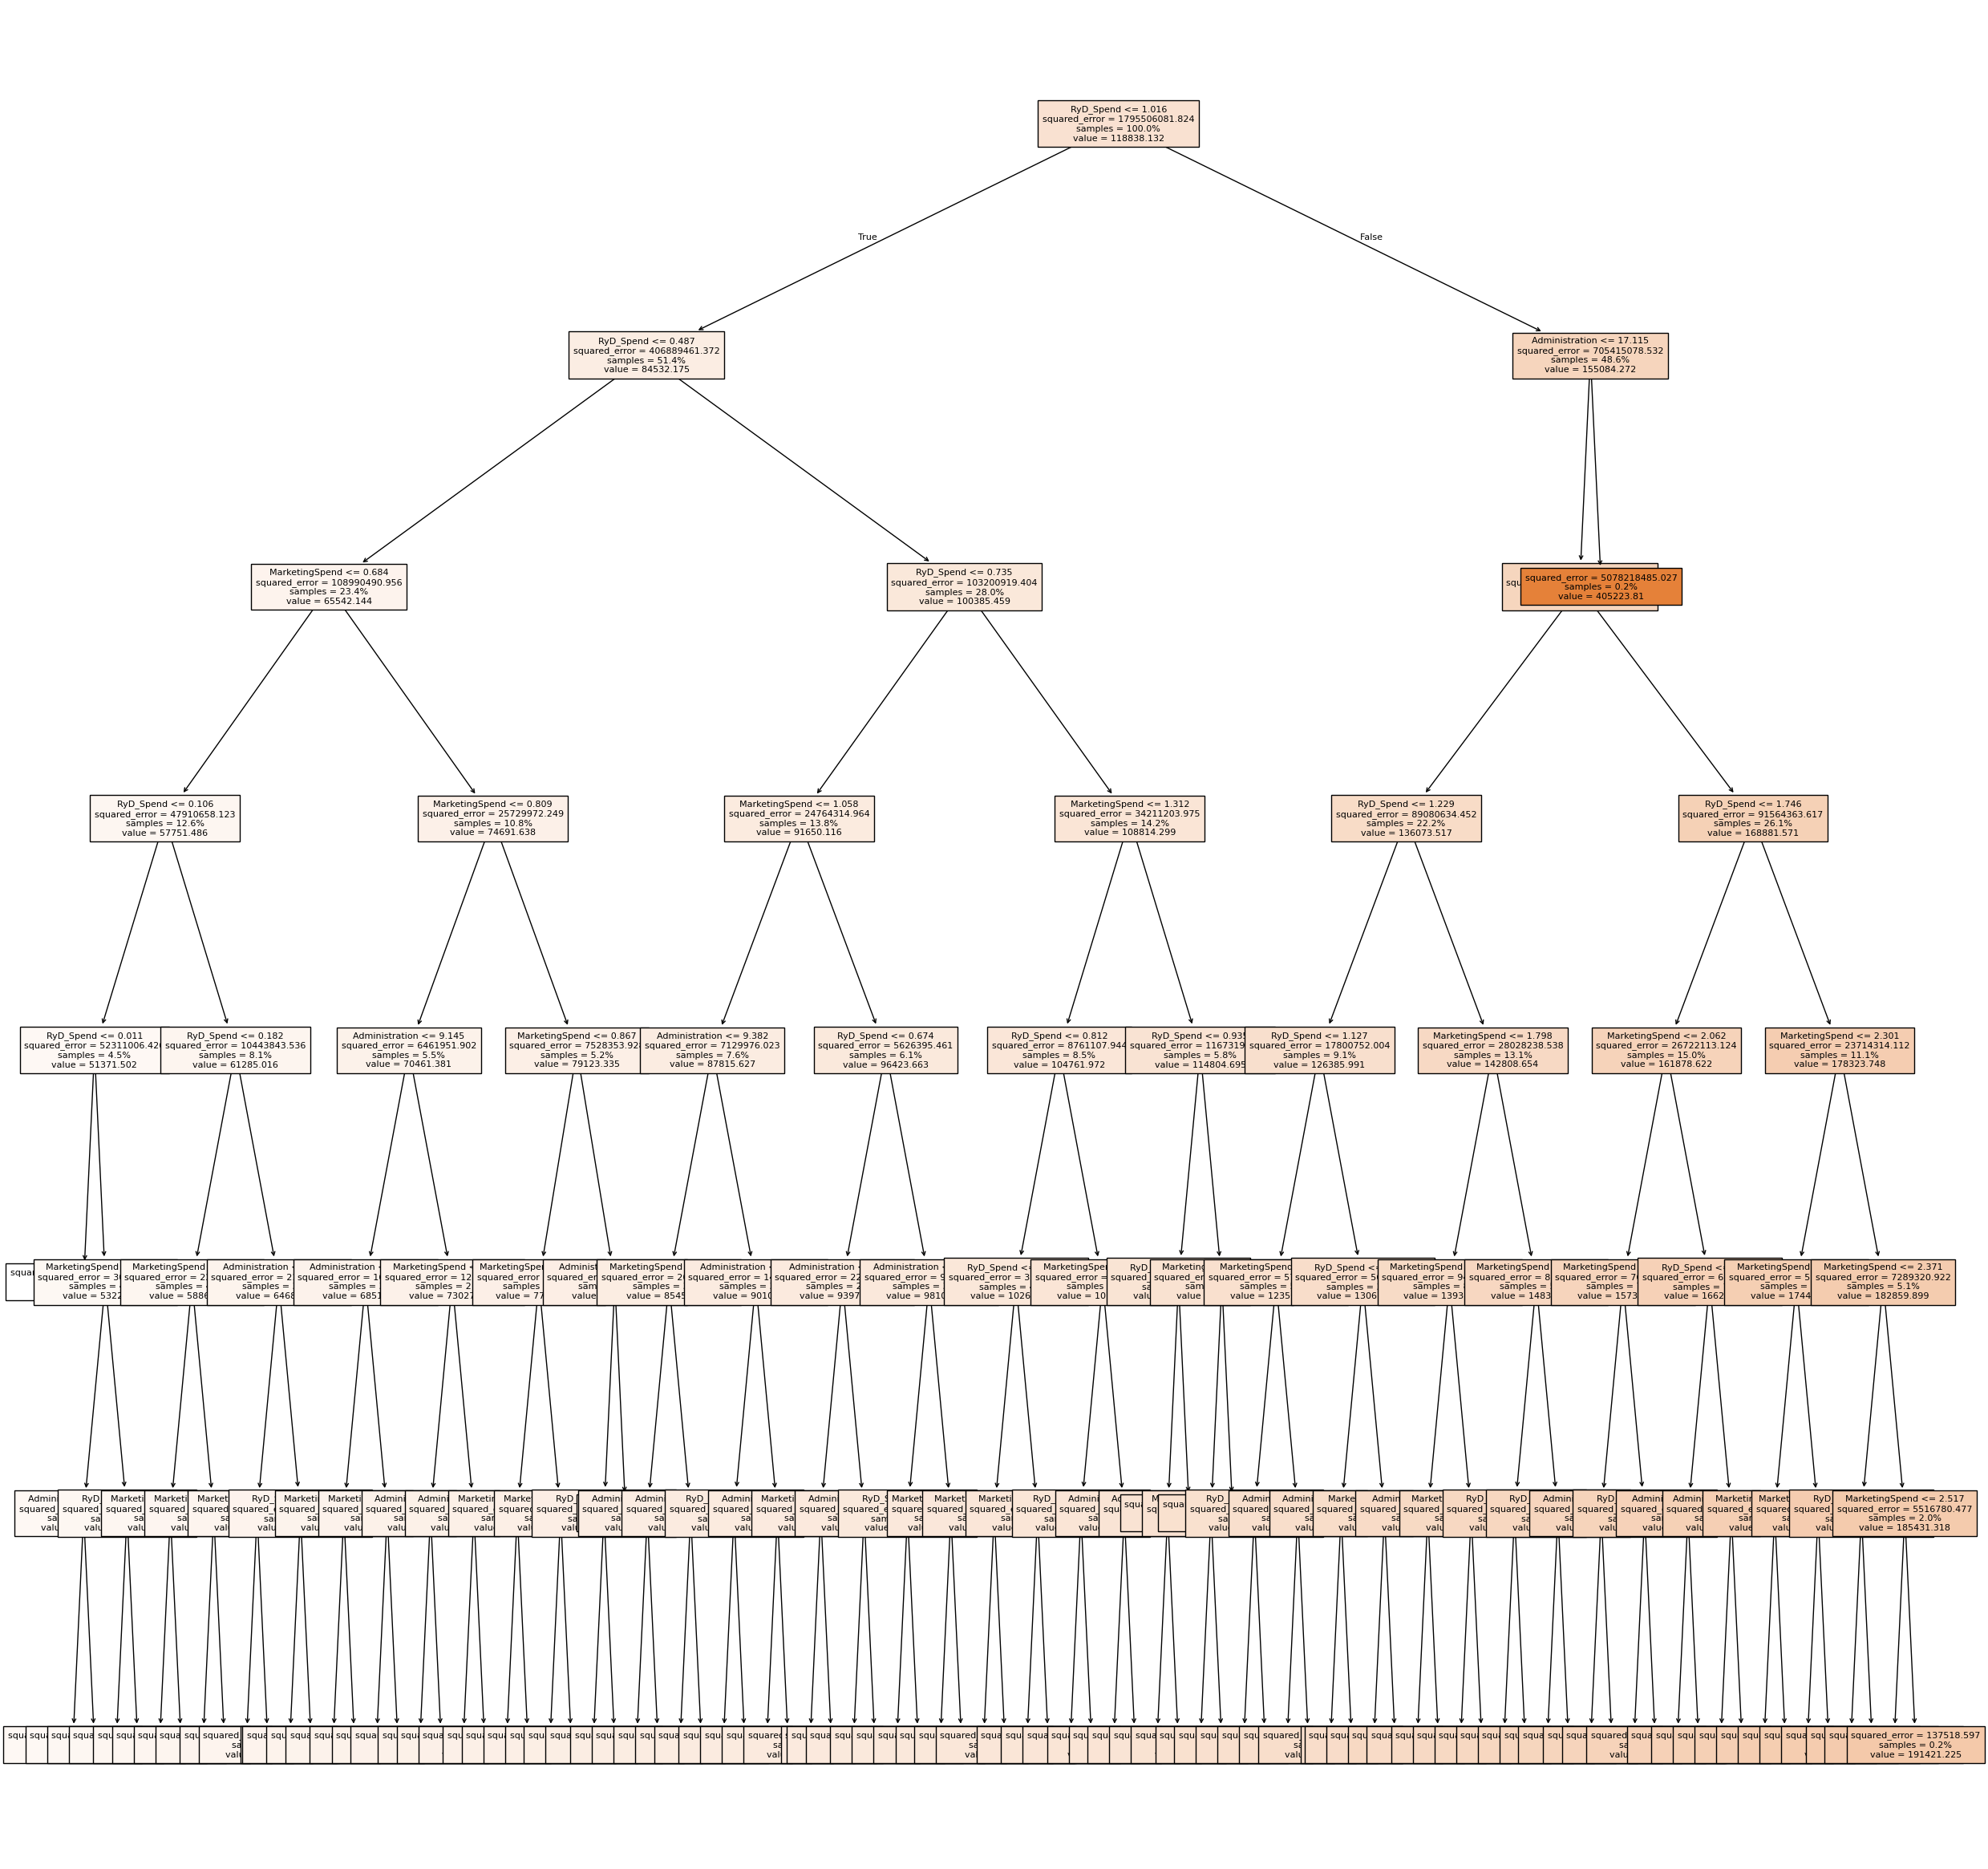

In [185]:
features = list(x_train.columns)
plt.figure(figsize=(30,30))
tree.plot_tree(decision_tree_regresion, feature_names=features, fontsize=8, filled=True, rounded=False, proportion=True)
plt.show()

In [186]:
pd.options.display.float_format = '{:.1f}'.format

In [187]:
prediccion_test_1 = decision_tree_regresion.predict(x_test_esc)
prediccion_test_2 = decision_tree_regresion.predict(x_test_esc2)

mae_test_1 = mean_absolute_error(y_test, prediccion_test_1)
mae_test_2 = mean_absolute_error(y_test2, prediccion_test_2)

mse_test_1 = mean_squared_error(y_test, prediccion_test_1)
mse_test_2 = mean_squared_error(y_test2, prediccion_test_2)

rmse_test_1 = np.sqrt(mse_test_1)
rmse_test_2 = np.sqrt(mse_test_2)

valores_conj_res = {'Test 1':[mae_test_1,mse_test_1,rmse_test_1], 'Test 2':[mae_test_2,mse_test_2,rmse_test_2]}
df_conj_res = pd.DataFrame(valores_conj_res, index=['MAE', 'MSE', 'RMSE'])
df_conj_res

,Test 1,Test 2
MAE,960.2,800.6
MSE,8108067.3,5544449.5
RMSE,2847.5,2354.7


Observamos que al presentarse una mayor cantidad de datos de test, el modelo generaliza mejor, ya que sus métricas son mejores.

## 3

* Descargar el conjunto de datos, PokemonDBCart. para realizar el trabajo práctico.

* Analizar los atributos del conjunto de datos (distribuciones, valores, outliers, tipos de datos, etc.).

* Generar dos conjuntos de datos considerando 80-20 y 70-30 para entrenar y evaluar los modelos.

## Segundo conjunto de datos (Pokemones)

In [188]:
label_encoder = LabelEncoder()
df_pokemon['TipoPokemon_codif'] = label_encoder.fit_transform(df_pokemon['TipoPokemon'])

df_pokemon_sin_nombre = df_pokemon.drop(['Nombre'], axis=1)
df_pokemon_ord = pd.get_dummies(df_pokemon_sin_nombre, columns=['TipoPokemon'])

df_pokemon_sin_nombre['TipoPokemon_codif'] = label_encoder.fit_transform(df_pokemon_sin_nombre['TipoPokemon'])

x_train_pokemon, x_test_pokemon, y_train_pokemon, y_test_pokemon = train_test_split(df_pokemon_ord.drop(['TipoPokemon_agua','TipoPokemon_bicho','TipoPokemon_electrico','TipoPokemon_fuego','TipoPokemon_hierba','TipoPokemon_normal','TipoPokemon_psiquico','TipoPokemon_roca'], axis=1), df_pokemon_sin_nombre['TipoPokemon_codif'], test_size=0.3, random_state=3425)
x_test_pokemon1, x_test_pokemon2, y_test_pokemon1, y_test_pokemon2 = train_test_split(x_test_pokemon, y_test_pokemon, test_size=0.5, random_state=9678)
x_train_pokemon.shape, x_test_pokemon1.shape, x_test_pokemon2.shape, y_train_pokemon.shape, y_test_pokemon1.shape, y_test_pokemon2.shape

((335, 7), (72, 7), (72, 7), (335,), (72,), (72,))

In [189]:
x_train_pokemon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 335 entries, 308 to 297
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Ataque             335 non-null    int64
 1   Defensa            335 non-null    int64
 2   Velocidad          335 non-null    int64
 3   HP                 335 non-null    int64
 4   SpAtaque           335 non-null    int64
 5   SpDefensa          335 non-null    int64
 6   TipoPokemon_codif  335 non-null    int64
dtypes: int64(7)
memory usage: 20.9 KB


In [190]:
x_train_pokemon.describe()

,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa,TipoPokemon_codif
count,335.0,335.0,335.0,335.0,335.0,335.0,335.0
mean,72.8,69.7,64.7,67.4,72.2,71.1,3.2
std,30.0,29.4,28.7,26.0,30.9,28.4,2.3
min,10.0,10.0,5.0,20.0,10.0,20.0,0.0
25%,50.0,49.0,45.0,50.0,50.0,50.0,1.0
50%,68.0,65.0,63.0,65.0,65.0,67.0,3.0
75%,90.0,85.0,85.0,79.0,91.5,88.5,5.0
max,181.0,230.0,151.0,255.0,194.0,230.0,7.0


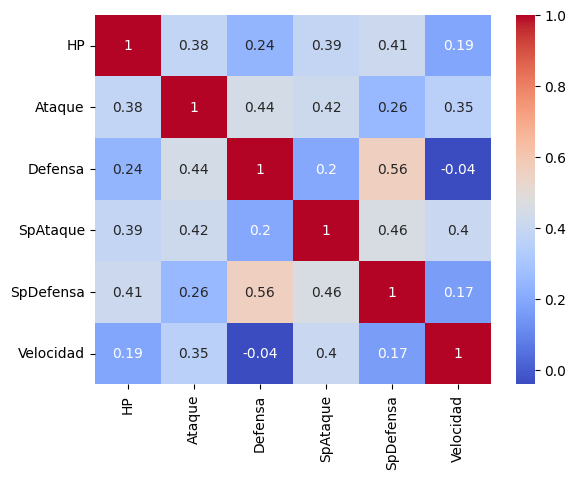

In [191]:
matriz_pokemon = x_train_pokemon[['HP','Ataque','Defensa','SpAtaque','SpDefensa' ,'Velocidad']].corr()
sns.heatmap(matriz_pokemon, annot=True, cmap='coolwarm')
plt.show()

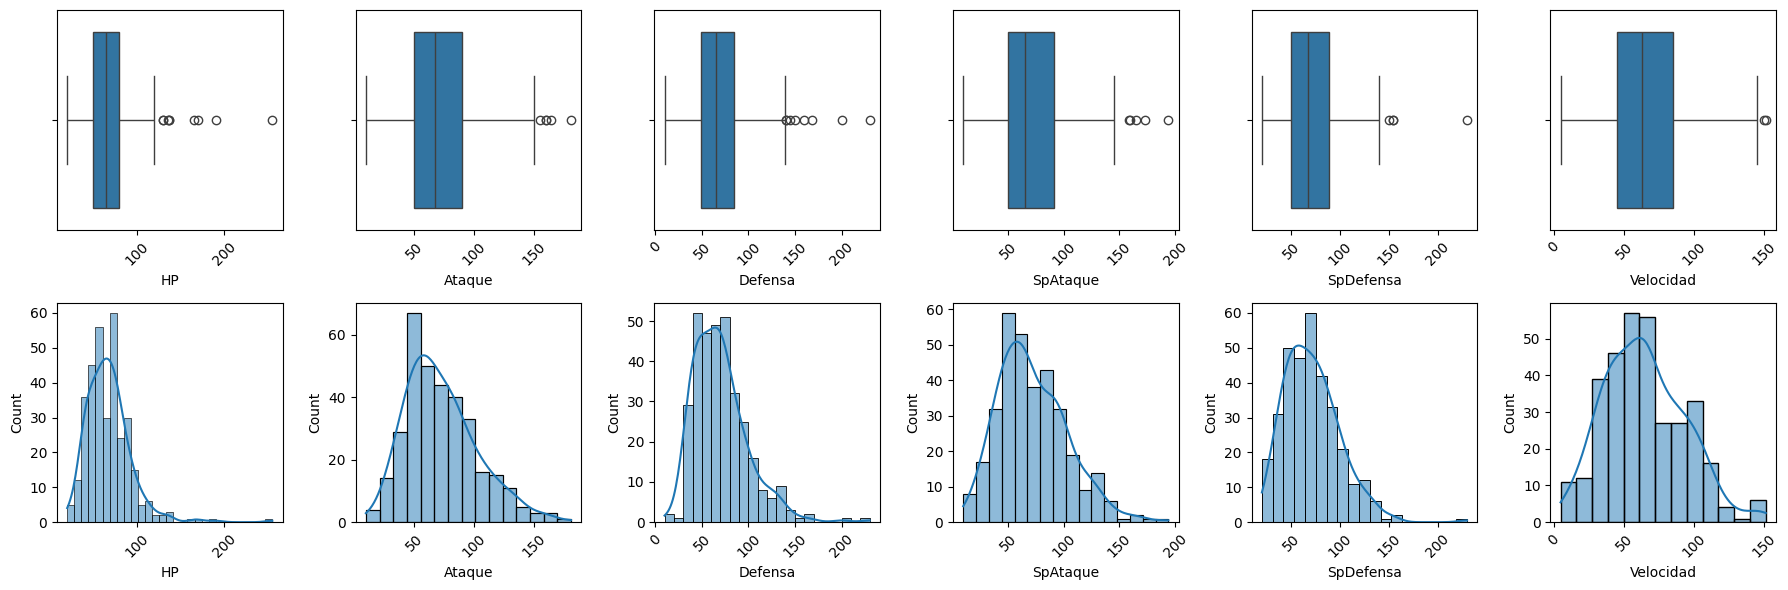

In [192]:
fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i, name in enumerate(x_train_pokemon[['HP','Ataque','Defensa','SpAtaque','SpDefensa' ,'Velocidad']]):

    sns.boxplot(x=name, data=x_train_pokemon, orient='h', ax=axes[0, i])
    axes[0, i].tick_params(axis='x', rotation=45)

    sns.histplot(x=name, data=x_train_pokemon, ax=axes[1, i], kde=True)
    axes[1, i].tick_params(axis='x', rotation=45)


fig.tight_layout()
plt.show()

## 4 Realizar la estimación del atributo TipoPokemon utilizando árboles de decisión (Clasificación)

In [193]:
decision_tree_pokemon_clas = DecisionTreeClassifier(random_state=5232)

param_grid = {'max_depth': [1,2,3,4,5,6,7,8], 'min_samples_leaf': [1,2,3,4,5], 'min_samples_split': [1,2,3,4], 'min_weight_fraction_leaf': [0.1, 0.2, 0.3], 'criterion': ['gini', 'entropy'] }

grid_search = GridSearchCV(estimator=decision_tree_pokemon_clas, param_grid=param_grid, scoring='accuracy', cv=4, n_jobs=-1)

grid_search.fit(x_train_pokemon, y_train_pokemon)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

Mejores hiperparámetros encontrados:
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.1}


In [194]:
decision_tree_pokemon_clas = tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=1,min_samples_split=2, min_weight_fraction_leaf=0.1 ,criterion='gini', random_state=5232)

decision_tree_pokemon_clas.fit(x_train_pokemon, y_train_pokemon)

DecisionTreeClassifier(max_depth=4, min_weight_fraction_leaf=0.1,
                       random_state=5232)

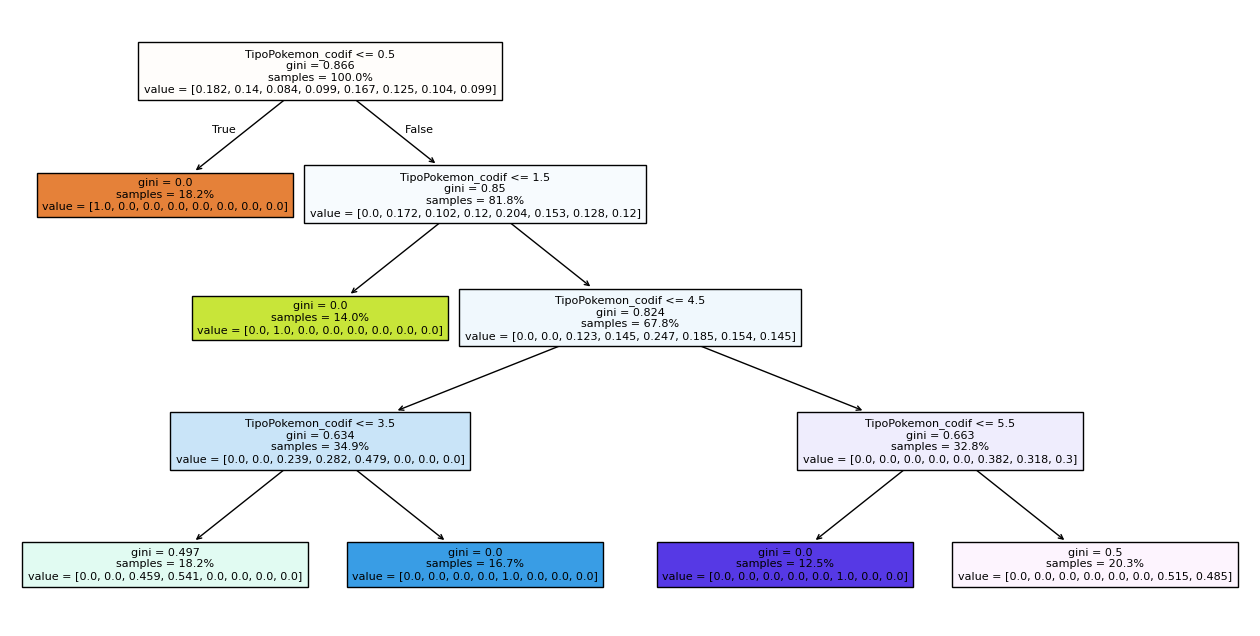

In [195]:
features_pokemon = list(x_train_pokemon.columns)

plt.figure(figsize=(16,8))
tree.plot_tree(decision_tree_pokemon_clas, feature_names=features_pokemon, fontsize=8, filled=True,  proportion=True)
plt.show()

In [196]:
predictions_train = decision_tree_pokemon_clas.predict(x_train_pokemon)

predictions_test1 = decision_tree_pokemon_clas.predict(x_test_pokemon1)
predictions_test2 = decision_tree_pokemon_clas.predict(x_test_pokemon2)
#--
accuracy_train = accuracy_score(y_train_pokemon, predictions_train)

accuracy_test1 = accuracy_score(y_test_pokemon1, predictions_test1)
accuracy_test2 = accuracy_score(y_test_pokemon2, predictions_test2)
#--
precision_train = precision_score(y_train_pokemon, predictions_train, average='weighted', zero_division=1)

precision_test1 = precision_score(y_test_pokemon1, predictions_test1, average='weighted', zero_division=1)
precision_test2 = precision_score(y_test_pokemon2, predictions_test2, average='weighted', zero_division=1)
#--
recall_train = recall_score(y_train_pokemon, predictions_train, average='weighted')

recall_test1 = recall_score(y_test_pokemon1, predictions_test1, average='weighted')
recall_test2 = recall_score(y_test_pokemon2, predictions_test2, average='weighted')

valores_resultados_pokemon = {'Accuracy': [accuracy_train,accuracy_test1,accuracy_test2], 'Precision': [precision_train,precision_test1,precision_test2], 'Recall': [recall_train,recall_test1,recall_test2]}
df_resultados = pd.DataFrame(valores_resultados_pokemon, index=['Train', 'Test 1', 'Test 2'])
df_resultados

,Accuracy,Precision,Recall
Train,0.8,0.9,0.8
Test 1,0.8,0.9,0.8
Test 2,0.8,0.9,0.8


## 5.

* Realizar la estimación del atributo TipoPokemon utilizando Bayes Ingenuo. Aquí deberá considerar un criterio de división de los atributos para discretizarlos. Mostrar los resultados sobre ambos conjuntos de test (Precisión, Exhaustividad y Exactitud)

In [197]:
modelo_gaussiano = GaussianNB()
modelo_gaussiano.fit(x_train_pokemon, y_train_pokemon)

GaussianNB()

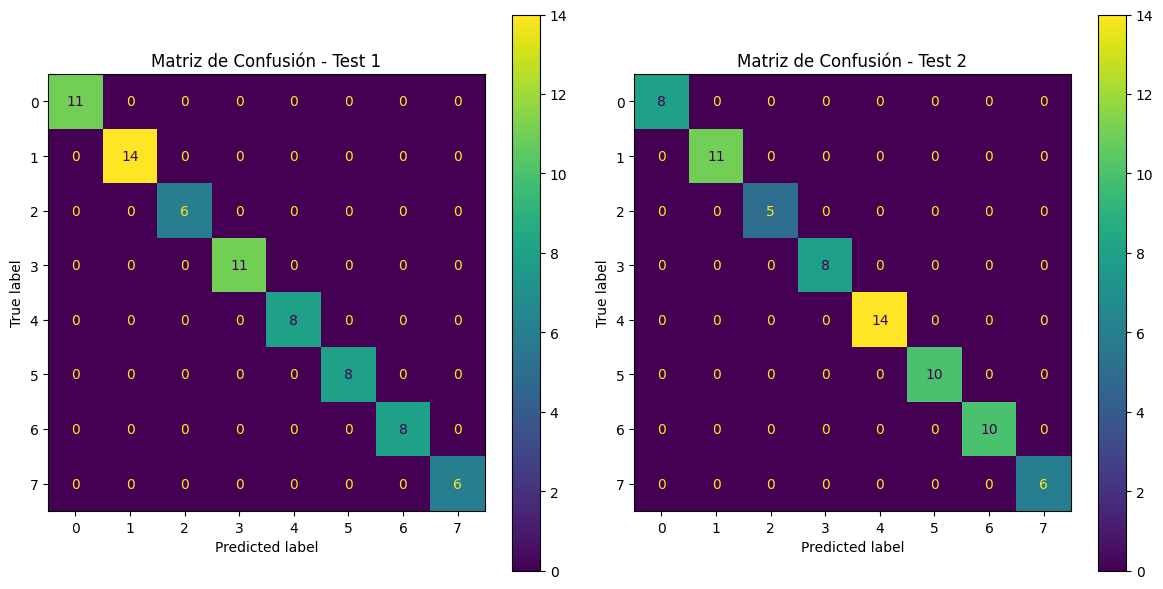

In [198]:
y_test_pred_GNB_1= modelo_gaussiano.predict(x_test_pokemon1) #test1
y_test_pred_GNB_2= modelo_gaussiano.predict(x_test_pokemon2) #test2

matriz_confusion_1 = metrics.confusion_matrix(y_test_pokemon1, y_test_pred_GNB_1)
matriz_confusion_2 = metrics.confusion_matrix(y_test_pokemon2, y_test_pred_GNB_2)

metrics.ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_1)
metrics.ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_2)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

metrics.ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_1).plot(ax=ax[0])
ax[0].set_title('Matriz de Confusión - Test 1')

metrics.ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_2).plot(ax=ax[1])
ax[1].set_title('Matriz de Confusión - Test 2')

plt.tight_layout()
plt.show()

In [199]:
precision_gnb_test1 = precision_score(y_test_pokemon1, y_test_pred_GNB_1, average='weighted', zero_division=1)
precision_gnb_test2 = precision_score(y_test_pokemon2, y_test_pred_GNB_2, average='weighted', zero_division=1)

accuracy_gnb_test1 = accuracy_score(y_test_pokemon1, y_test_pred_GNB_1)
accuracy_gnb_test2 = accuracy_score(y_test_pokemon2, y_test_pred_GNB_2)

recall_gnb_test1 = recall_score(y_test_pokemon1, y_test_pred_GNB_1, average='weighted')
recall_gnb_test2 = recall_score(y_test_pokemon2, y_test_pred_GNB_2, average='weighted')

metricas_gnb = pd.DataFrame({'Precision': [precision_gnb_test1, precision_gnb_test2], 'Accuracy': [accuracy_gnb_test1, accuracy_gnb_test2], 'Recall': [recall_gnb_test1, recall_gnb_test2]})
metricas_gnb

,Precision,Accuracy,Recall
0,1.0,1.0,1.0
1,1.0,1.0,1.0


BernoulliNB

In [200]:
model_BernoulliNB = BernoulliNB()
model_BernoulliNB.fit(x_train_pokemon, y_train_pokemon)

BernoulliNB()

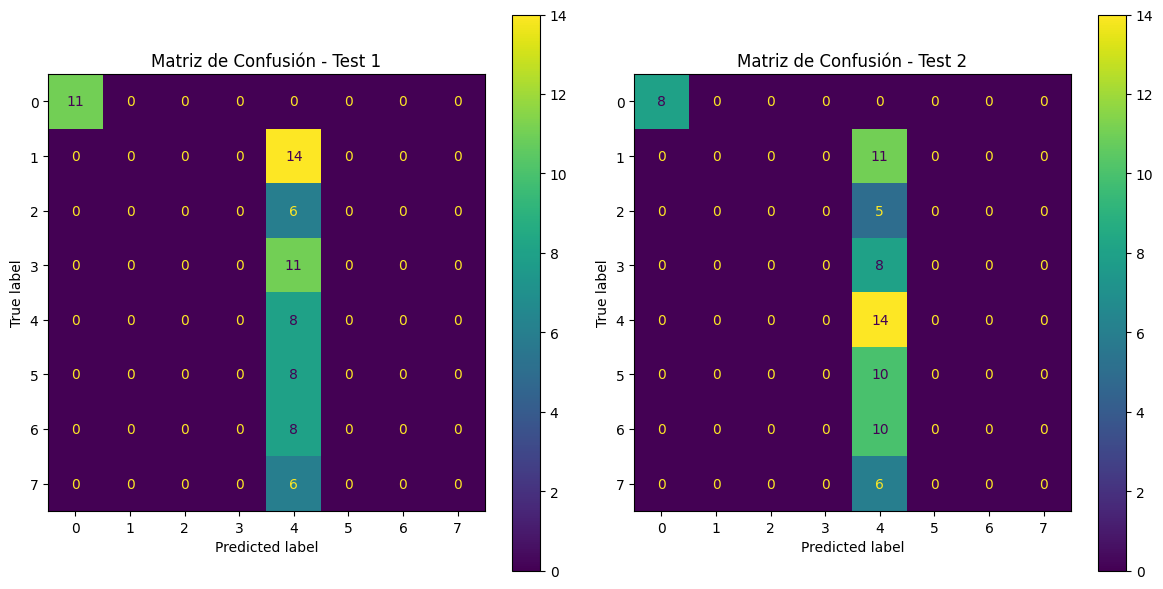

In [201]:
y_pred_BNB_test1 = model_BernoulliNB.predict(x_test_pokemon1)
y_pred_BNB_test2 = model_BernoulliNB.predict(x_test_pokemon2)

bernoulli_matriz_confusion_1 = metrics.confusion_matrix(y_test_pokemon1, y_pred_BNB_test1)
bernoulli_matriz_confusion_2 = metrics.confusion_matrix(y_test_pokemon2, y_pred_BNB_test2)

metrics.ConfusionMatrixDisplay(confusion_matrix=bernoulli_matriz_confusion_1)
metrics.ConfusionMatrixDisplay(confusion_matrix=bernoulli_matriz_confusion_2)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

metrics.ConfusionMatrixDisplay(confusion_matrix=bernoulli_matriz_confusion_1).plot(ax=ax[0])
ax[0].set_title('Matriz de Confusión - Test 1')

metrics.ConfusionMatrixDisplay(confusion_matrix=bernoulli_matriz_confusion_2).plot(ax=ax[1])
ax[1].set_title('Matriz de Confusión - Test 2')

plt.tight_layout()
plt.show()

In [202]:
precision_bnb_test1 = precision_score(y_test_pokemon1, y_pred_BNB_test1, average='weighted', zero_division=1)
precision_bnb_test2 = precision_score(y_test_pokemon2, y_pred_BNB_test2, average='weighted', zero_division=1)

accuracy_bnb_test1 = accuracy_score(y_test_pokemon1, y_pred_BNB_test1)
accuracy_bnb_test2 = accuracy_score(y_test_pokemon2, y_pred_BNB_test2)

recall_bnb_test1 = recall_score(y_test_pokemon1, y_pred_BNB_test1, average='weighted')
recall_bnb_test2 = recall_score(y_test_pokemon2, y_pred_BNB_test2, average='weighted')

metricas_bnb = pd.DataFrame({'Precision': [precision_bnb_test1, precision_bnb_test2], 'Accuracy': [accuracy_bnb_test1, accuracy_bnb_test2], 'Recall': [recall_bnb_test1, recall_bnb_test2]})
metricas_bnb

,Precision,Accuracy,Recall
0,0.9,0.3,0.3
1,0.8,0.3,0.3


In [203]:
modelo_naivebayes = MultinomialNB()
modelo_naivebayes.fit(x_train_pokemon, y_train_pokemon)

MultinomialNB()

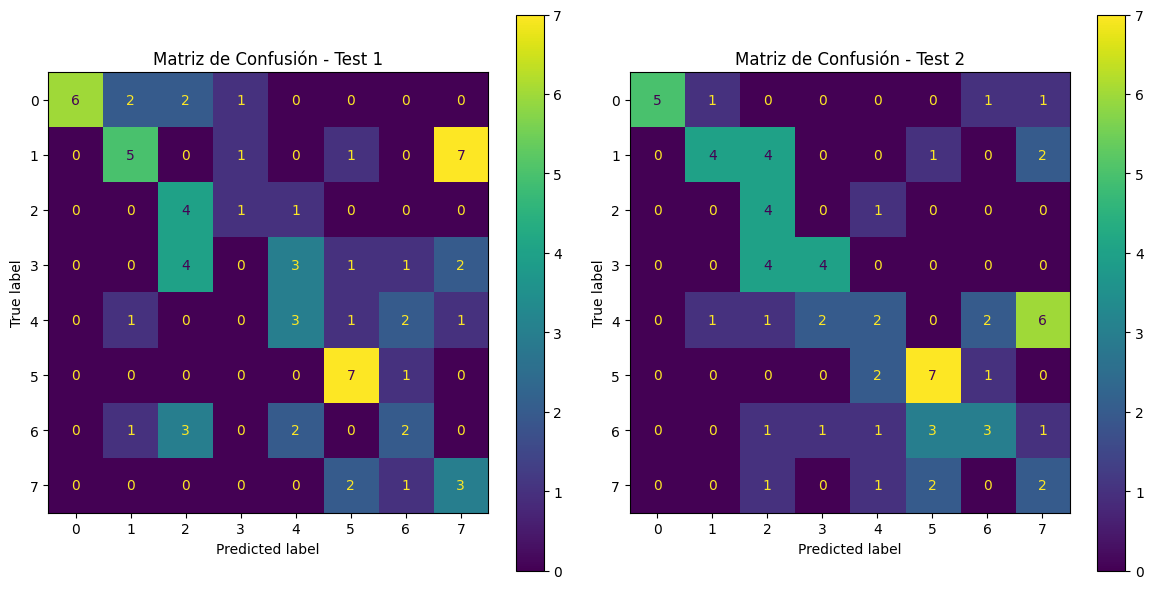

In [204]:
y_naivebayes_pred_test1 = modelo_naivebayes.predict(x_test_pokemon1)
y_naivebayes_pred_test2 = modelo_naivebayes.predict(x_test_pokemon2)

naivebayes_matriz_confusion_1 = metrics.confusion_matrix(y_test_pokemon1, y_naivebayes_pred_test1)
naivebayes_matriz_confusion_2 = metrics.confusion_matrix(y_test_pokemon2, y_naivebayes_pred_test2)

metrics.ConfusionMatrixDisplay(confusion_matrix=naivebayes_matriz_confusion_1)
metrics.ConfusionMatrixDisplay(confusion_matrix=naivebayes_matriz_confusion_2)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

metrics.ConfusionMatrixDisplay(confusion_matrix=naivebayes_matriz_confusion_1).plot(ax=ax[0])
ax[0].set_title('Matriz de Confusión - Test 1')

metrics.ConfusionMatrixDisplay(confusion_matrix=naivebayes_matriz_confusion_2).plot(ax=ax[1])
ax[1].set_title('Matriz de Confusión - Test 2')

plt.tight_layout()
plt.show()

In [205]:
precision_naivebayes_test1 = precision_score(y_test_pokemon1, y_naivebayes_pred_test1, average='weighted', zero_division=1)
precision_naivebayes_test2 = precision_score(y_test_pokemon2, y_naivebayes_pred_test2, average='weighted', zero_division=1)

accuracy_naivebayes_test1 = accuracy_score(y_test_pokemon1, y_naivebayes_pred_test1)
accuracy_naivebayes_test2 = accuracy_score(y_test_pokemon2, y_naivebayes_pred_test2)

recall_naivebayes_test1 = recall_score(y_test_pokemon1, y_naivebayes_pred_test1, average='weighted')
recall_naivebayes_test2 = recall_score(y_test_pokemon2, y_naivebayes_pred_test2, average='weighted')

metricas_naivebayes = pd.DataFrame({'Precision': [precision_naivebayes_test1, precision_naivebayes_test2], 'Accuracy': [accuracy_naivebayes_test1, accuracy_naivebayes_test2], 'Recall': [recall_naivebayes_test1, recall_naivebayes_test2]})
metricas_naivebayes

,Precision,Accuracy,Recall
0,0.4,0.4,0.4
1,0.5,0.4,0.4


# 6
* Realizar la estimación del atributo TipoPokemon utilizando k-NN analizando los
parámetros cantidad de vecinos, métrica y valor de p. Mostrar los resultados sobre ambos
conjuntos de test (Precisión, Exhaustividad y Exactitud).

In [206]:
best_f1 = 0
best_recall = 0
best_n_neighbors = 0
best_p = 0
best_weights = ""
best_results = None

p_values = [1, 2]
weights_values = ['uniform', 'distance']

for p in p_values:
    for weight in weights_values:
        for cantidad in range(25, 100, 1):
            knn_model = KNeighborsClassifier(n_neighbors=cantidad, p=p, weights=weight)
            knn_model.fit(x_train_pokemon, y_train_pokemon)

            knn_prediccion_test1 = knn_model.predict(x_test_pokemon1)
            knn_prediccion_test2 = knn_model.predict(x_test_pokemon2)

            f1_knn_test1 = f1_score(y_test_pokemon1, knn_prediccion_test1, average='weighted')
            f1_knn_test2 = f1_score(y_test_pokemon2, knn_prediccion_test2, average='weighted')

            recall_knn_test1 = recall_score(y_test_pokemon1, knn_prediccion_test1, average='weighted')
            recall_knn_test2 = recall_score(y_test_pokemon2, knn_prediccion_test2, average='weighted')

            avg_f1 = (f1_knn_test1 + f1_knn_test2) / 2
            avg_recall = (recall_knn_test1 + recall_knn_test2) / 2

            if avg_f1 > best_f1 or (avg_f1 == best_f1 and avg_recall > best_recall):
                best_f1 = avg_f1
                best_recall = avg_recall
                best_n_neighbors = cantidad
                best_p = p
                best_weights = weight

                valores_resultados_pokemon_knn = {
                    'Accuracy': [accuracy_score(y_test_pokemon1, knn_prediccion_test1), accuracy_score(y_test_pokemon2, knn_prediccion_test2)],
                    'Precision': [precision_score(y_test_pokemon1, knn_prediccion_test1, average='weighted', zero_division=1),
                                  precision_score(y_test_pokemon2, knn_prediccion_test2, average='weighted', zero_division=1)],
                    'Recall': [recall_knn_test1, recall_knn_test2],
                    'F1-score': [f1_knn_test1, f1_knn_test2]}
                best_results = pd.DataFrame(valores_resultados_pokemon_knn, index=['Test 1', 'Test 2'])


print(f"mejor numero de vecinos (n_neighbors): {best_n_neighbors}, mejor valor de p: {best_p}, mejor esquema de pesos (weights): {best_weights}")

mejor numero de vecinos (n_neighbors): 36, mejor valor de p: 1, mejor esquema de pesos (weights): distance


In [207]:
knn_model = KNeighborsClassifier(n_neighbors=36,p=1,weights='distance')

knn_model.fit(x_train_pokemon, y_train_pokemon)

knn_prediccion_test1 = knn_model.predict(x_test_pokemon1)
knn_prediccion_test2 = knn_model.predict(x_test_pokemon2)

accuracy_knn_test1 = accuracy_score(y_test_pokemon1, knn_prediccion_test1)
accuracy_knn_test2 = accuracy_score(y_test_pokemon2, knn_prediccion_test2)

precision_knn_test1 = precision_score(y_test_pokemon1, knn_prediccion_test1, average='weighted', zero_division=1)
precision_knn_test2 = precision_score(y_test_pokemon2, knn_prediccion_test2, average='weighted', zero_division=1)

recall_knn_test1 = recall_score(y_test_pokemon1, knn_prediccion_test1, average='weighted')
recall_knn_test2 = recall_score(y_test_pokemon2, knn_prediccion_test2, average='weighted')

f1_knn_test1 = f1_score(y_test_pokemon1, knn_prediccion_test1, average='weighted')
f1_knn_test2 = f1_score(y_test_pokemon2, knn_prediccion_test2, average='weighted')

valores_resultados_pokemon_knn = {'Accuracy': [accuracy_knn_test1,accuracy_knn_test2], 'Precision': [precision_knn_test1,precision_knn_test2], 'Recall': [recall_knn_test1,recall_knn_test2], 'F1-score': [f1_knn_test1,f1_knn_test2]}
df_resultados_knn = pd.DataFrame(valores_resultados_pokemon_knn, index=['Test 1', 'Test 2'])
df_resultados_knn

,Accuracy,Precision,Recall,F1-score
Test 1,0.3,0.4,0.3,0.3
Test 2,0.4,0.5,0.4,0.4
